<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #11: Twitter
`Fecha de entrega: Mayo 20, 2021 (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

###  `[25 pts]` Punto 1: Extraer Tuits
Extraer mínimo 100 tuits de Twitter usando la API

❌ No escoger un tema de los que hicimos en clase (día de las madres, Giro de Italia, #EraGoldeYepes)

In [1]:
import os
import pandas as pd
import json
import tweepy
import re 
import regex
import emoji
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

import scipy.cluster.hierarchy as sch
import numpy as np

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:

# Obtener variables de entorno desde sistema local
API_KEY = os.getenv('TWITTER_API_KEY')
API_SECRET_KEY = os.environ.get('TWITTER_API_SECRET_KEY')
BEARER_TOKEN =os.environ.get('TWITTER_BEARER_TOKEN')
ACCESS_TOKEN= os.environ.get('TWITTER_ACCESS_TOKEN')
ACCESS_TOKEN_SECRET= os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')


auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweets = tweepy.Cursor(api.search,
                       q=['Matarife -RT'],
                       lang='es',
                       geocode='4.3646,-74.0414,100km',
                       tweet_mode='extended',
                       include_rts=False,
                       ).items(110)

# Objeto generador
t = [tweet for tweet in tweets]

t_processed = []

for tweet in t: 
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append('Bogotá')
    temp.append(tweet.user.location)
    temp.append(tweet.id)
    temp.append(f"https://twitter.com/i/web/stuatus/{tweet.id}")
    
    t_processed.append(temp)
   
datos = pd.DataFrame(t_processed)
datos.columns = ['tweets', 'fecha', 'ciudad', 'localizacion_usuario', 'id', 'enlace']
datos.head()


,tweets,fecha,ciudad,localizacion_usuario,id,enlace
0,@Csar38329864 @HijoDeCartagena @petrogustavo N...,2021-05-20 18:55:06,Bogotá,"Funza, Colombia",1395453043391488008,https://twitter.com/i/web/stuatus/139545304339...
1,"Estos chimbos @German_Vargas, pobres engendros...",2021-05-20 18:54:54,Bogotá,"Bogotá, Colombia",1395452992602742794,https://twitter.com/i/web/stuatus/139545299260...
2,#medioscomplices en Colombia no se atreven di...,2021-05-20 18:48:32,Bogotá,"Villavicencio, Colombia",1395451391913734154,https://twitter.com/i/web/stuatus/139545139191...
3,@ANIABELLO_R ojo con el matarife,2021-05-20 18:41:57,Bogotá,Bogota,1395449732697366537,https://twitter.com/i/web/stuatus/139544973269...
4,Gracias #kpopers por erradicar la propaganda f...,2021-05-20 18:37:52,Bogotá,"Bogotá, D.C., Colombia",1395448704891555846,https://twitter.com/i/web/stuatus/139544870489...


In [3]:
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweets']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
    
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")
        
    return text, links, hashtags, mentions
  
  
datos[['texto_limpio', 'enlaces', 'hashtags', 'menciones']] = datos.apply(text_clean, axis=1, result_type='expand')
datos.head()

,tweets,fecha,ciudad,localizacion_usuario,id,enlace,texto_limpio,enlaces,hashtags,menciones
0,@Csar38329864 @HijoDeCartagena @petrogustavo N...,2021-05-20 18:55:06,Bogotá,"Funza, Colombia",1395453043391488008,https://twitter.com/i/web/stuatus/139545304339...,Ni hablar del matarife,[],[],"[@Csar38329864, @HijoDeCartagena, @petrogustavo]"
1,"Estos chimbos @German_Vargas, pobres engendros...",2021-05-20 18:54:54,Bogotá,"Bogotá, Colombia",1395452992602742794,https://twitter.com/i/web/stuatus/139545299260...,Estos chimbos pobres engendros del están tan...,"[https://t.co/pGxrHtTJyv, https://t.co/pNiQ436...","[#Matarife,]","[@German_Vargas,, @AirbagInfo.]"
2,#medioscomplices en Colombia no se atreven di...,2021-05-20 18:48:32,Bogotá,"Villavicencio, Colombia",1395451391913734154,https://twitter.com/i/web/stuatus/139545139191...,en Colombia no se atreven divulgar por miedo...,[https://t.co/b7EZgIiAxj],"[#medioscomplices, #Matarife, #ParoNacionalInd...",[]
3,@ANIABELLO_R ojo con el matarife,2021-05-20 18:41:57,Bogotá,Bogota,1395449732697366537,https://twitter.com/i/web/stuatus/139544973269...,ojo con el matarife,[],[],[@ANIABELLO_R]
4,Gracias #kpopers por erradicar la propaganda f...,2021-05-20 18:37:52,Bogotá,"Bogotá, D.C., Colombia",1395448704891555846,https://twitter.com/i/web/stuatus/139544870489...,Gracias por erradicar la propaganda fascista ...,[],[#kpopers],[]


In [4]:
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list
  
  

datos['emojis'] = datos['texto_limpio'].apply(lambda text: get_emojis(text))
datos.head()

,tweets,fecha,ciudad,localizacion_usuario,id,enlace,texto_limpio,enlaces,hashtags,menciones,emojis
0,@Csar38329864 @HijoDeCartagena @petrogustavo N...,2021-05-20 18:55:06,Bogotá,"Funza, Colombia",1395453043391488008,https://twitter.com/i/web/stuatus/139545304339...,Ni hablar del matarife,[],[],"[@Csar38329864, @HijoDeCartagena, @petrogustavo]",[]
1,"Estos chimbos @German_Vargas, pobres engendros...",2021-05-20 18:54:54,Bogotá,"Bogotá, Colombia",1395452992602742794,https://twitter.com/i/web/stuatus/139545299260...,Estos chimbos pobres engendros del están tan...,"[https://t.co/pGxrHtTJyv, https://t.co/pNiQ436...","[#Matarife,]","[@German_Vargas,, @AirbagInfo.]",[]
2,#medioscomplices en Colombia no se atreven di...,2021-05-20 18:48:32,Bogotá,"Villavicencio, Colombia",1395451391913734154,https://twitter.com/i/web/stuatus/139545139191...,en Colombia no se atreven divulgar por miedo...,[https://t.co/b7EZgIiAxj],"[#medioscomplices, #Matarife, #ParoNacionalInd...",[],[]
3,@ANIABELLO_R ojo con el matarife,2021-05-20 18:41:57,Bogotá,Bogota,1395449732697366537,https://twitter.com/i/web/stuatus/139544973269...,ojo con el matarife,[],[],[@ANIABELLO_R],[]
4,Gracias #kpopers por erradicar la propaganda f...,2021-05-20 18:37:52,Bogotá,"Bogotá, D.C., Colombia",1395448704891555846,https://twitter.com/i/web/stuatus/139544870489...,Gracias por erradicar la propaganda fascista ...,[],[#kpopers],[],[💩]


###  `[25 pts]` Punto 2: Hacer una visualización sobre esos tuits

* Se realizaron dos gráficas relacionadas con los tweets recuperados, a saber: 
    Agrupaciones de tweets con el método k-means y tweets por hora (gráfico visto en clase).
    

In [5]:
# Definición de función de pre-procesamiento
stopwords_sp = stopwords.words('spanish')
stopwords_sp.extend(["https", "http", "co", "com", "edu","eu","Álvaro","Uribe", "Vélez", "Matarife", "u","û","q","k","w","a","p","pg","b","c","f","z","j",
                  "v","n","g","e","r","x","l","h","st","rt","lol","aa", "vélez","vélezel","álvaro","uribe"])

def preProcesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

In [6]:
tfidf_vect = TfidfVectorizer(preprocessor=preProcesado)
tfidf = tfidf_vect.fit_transform(datos.texto_limpio.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())
tfidf_matrix

,abogado,abrir,acabando,acabar,acepta,aceptar,aceptará,acercando,acueductos,acuerdese,...,voz,vuelto,vándalos,vínculos,yamhure,yno,época,ética,órdenes,único
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.231277,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.0,0.0,0.0,0.0,0.213926,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
107,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.290962,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


env: OMP_NUM_THREADS=8


D:\ProgramFiles\Anaconda3.2020.11\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



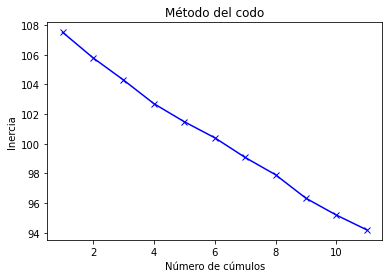

In [7]:
%set_env OMP_NUM_THREADS=8
ks = []
k_inertias = []

for k in range(1,12):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)
    
    
# list(zip(ks,k_inertias))

plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');

In [8]:
k = 3
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

datos['cluster'] = model.labels_
datos

,tweets,fecha,ciudad,localizacion_usuario,id,enlace,texto_limpio,enlaces,hashtags,menciones,emojis,cluster
0,@Csar38329864 @HijoDeCartagena @petrogustavo N...,2021-05-20 18:55:06,Bogotá,"Funza, Colombia",1395453043391488008,https://twitter.com/i/web/stuatus/139545304339...,Ni hablar del matarife,[],[],"[@Csar38329864, @HijoDeCartagena, @petrogustavo]",[],1
1,"Estos chimbos @German_Vargas, pobres engendros...",2021-05-20 18:54:54,Bogotá,"Bogotá, Colombia",1395452992602742794,https://twitter.com/i/web/stuatus/139545299260...,Estos chimbos pobres engendros del están tan...,"[https://t.co/pGxrHtTJyv, https://t.co/pNiQ436...","[#Matarife,]","[@German_Vargas,, @AirbagInfo.]",[],0
2,#medioscomplices en Colombia no se atreven di...,2021-05-20 18:48:32,Bogotá,"Villavicencio, Colombia",1395451391913734154,https://twitter.com/i/web/stuatus/139545139191...,en Colombia no se atreven divulgar por miedo...,[https://t.co/b7EZgIiAxj],"[#medioscomplices, #Matarife, #ParoNacionalInd...",[],[],2
3,@ANIABELLO_R ojo con el matarife,2021-05-20 18:41:57,Bogotá,Bogota,1395449732697366537,https://twitter.com/i/web/stuatus/139544973269...,ojo con el matarife,[],[],[@ANIABELLO_R],[],1
4,Gracias #kpopers por erradicar la propaganda f...,2021-05-20 18:37:52,Bogotá,"Bogotá, D.C., Colombia",1395448704891555846,https://twitter.com/i/web/stuatus/139544870489...,Gracias por erradicar la propaganda fascista ...,[],[#kpopers],[],[💩],1
...,...,...,...,...,...,...,...,...,...,...,...,...
105,@DanielSamperO Pues así Santos tenga toda la r...,2021-05-20 11:58:42,Bogotá,"Bogotá, D.C., Colombia",1395348252728479754,https://twitter.com/i/web/stuatus/139534825272...,"Pues así Santos tenga toda la razón, el cerdo...",[],[],[@DanielSamperO],[],1
106,@CaliDigna_ @Victori10406848 @ANTIENCAPUCHAD1 ...,2021-05-20 11:57:09,Bogotá,"Bogotá, D.C., Colombia",1395347862519681026,https://twitter.com/i/web/stuatus/139534786251...,"Jajaja hpta bodega de mierda, hampon a eso...",[],[],"[@CaliDigna_, @Victori10406848, @ANTIENCAPUCHA...",[],0
107,@FNAraujoR @SulayBuitrago El casett les quedó ...,2021-05-20 11:53:39,Bogotá,"Bogotá, D.C., Colombia",1395346983536168962,https://twitter.com/i/web/stuatus/139534698353...,"El casett les quedó mal grabado, ahora inves...",[],[],"[@FNAraujoR, @SulayBuitrago]",[],0
108,@AlvaroUribeVel Que dolor Colombia inundado en...,2021-05-20 11:47:22,Bogotá,Bogota,1395345401079869445,https://twitter.com/i/web/stuatus/139534540107...,Que dolor Colombia inundado en sangre por cul...,[],"[#Matarife, #Genocida]",[@AlvaroUribeVel],[],2


In [9]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = datos['cluster'].value_counts()
clust_cnt_pct = datos['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in datos.iloc[nbrs.kneighbors([centroids[i]])[1][0]].texto_limpio.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("********************************************")
    print()

Cluster # 0
Tiene 36 registros (32.73% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
solo ahora gobierno matarife usted si versión mas uribistas espalda ser sabemos tan nunca bogotá pueblo salir creen cubriendo esbirros 

DOCUMENTOS MÁS REPRESENTATIVOS
 ***  El chiste se cuenta por si solo no se supone que este gobierno seria el mas austero.
Jajaja hay sñr Matarife ya usted no sabe con que salir.

 ***    Recuerda que ellos solo repiten lo que dice el Matarife, traidor porque no quiso ser más el títere de ese genocida, no te desgastes, ellos no piensan por si solos, solo repite

 ***   Obvio no, no somos ilusos, sabemos que a los Uribistas no les interesa nada, solo estar bien ellos y aceptar todo lo que diga el Matarife. No se preocupe que a nosotros la suya nos importa menos y más ahora que están al borde de la extinción 😬


********************************************

Cluster # 1
Tiene 51 registros (46.36% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
matarife orden hermana abogado hij

In [10]:
clusters = {0: "Cluster 0 - PARO", 
            1: "Cluster 1 - DICTADURA",
            2: "Cluster 2 - EXPROPIACIÓN",
            
}

datos['nombres_clusters'] = datos['cluster'].apply(lambda val: clusters[val])
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = datos.nombres_clusters.values
result['texto'] = datos.texto_limpio.apply(lambda val: val[:])

colorsIdx = {
            "Cluster 0 - PARO": "yellow", 
            "Cluster 1 - DICTADURA": "blue",
            "Cluster 2 - EXPROPIACIÓN": "red" }

result['colores'] = result['cluster'].map(colorsIdx)
result

,X,Y,cluster,texto,colores
0,-0.043356,-0.066405,Cluster 1 - DICTADURA,Ni hablar del matarife,blue
1,-0.072764,0.042337,Cluster 0 - PARO,Estos chimbos pobres engendros del están tan...,yellow
2,0.035050,0.089876,Cluster 2 - EXPROPIACIÓN,en Colombia no se atreven divulgar por miedo...,red
3,-0.043752,-0.046910,Cluster 1 - DICTADURA,ojo con el matarife,blue
4,0.080625,-0.185238,Cluster 1 - DICTADURA,Gracias por erradicar la propaganda fascista ...,blue
...,...,...,...,...,...
105,-0.058016,-0.019382,Cluster 1 - DICTADURA,"Pues así Santos tenga toda la razón, el cerdo...",blue
106,-0.063660,-0.026043,Cluster 0 - PARO,"Jajaja hpta bodega de mierda, hampon a eso...",yellow
107,-0.057195,-0.050514,Cluster 0 - PARO,"El casett les quedó mal grabado, ahora inves...",yellow
108,0.001706,0.104377,Cluster 2 - EXPROPIACIÓN,Que dolor Colombia inundado en sangre por cul...,red


### Gráfico de agrupaciones de Tweets:

In [11]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="KMEANS- TWEETS")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

In [12]:
datos['hora'] = datos['fecha'].dt.floor('H').dt.time

In [13]:
conteos = pd.DataFrame(datos.hora.value_counts()).reset_index()
conteos.columns = ['hora', 'cuenta']
conteos = conteos.sort_values('hora')
conteos

,hora,cuenta
7,11:00:00,6
1,12:00:00,20
3,13:00:00,18
2,14:00:00,19
0,15:00:00,20
5,16:00:00,9
6,17:00:00,6
4,18:00:00,12


### Gráfico de tweets por hora

In [14]:

trace = go.Scatter(x=conteos.hora.values,
                   y=conteos.cuenta.values,
                   text=[f"Fecha: {f}<br>Tuits: {c}" for f,c in zip(conteos.hora.values,conteos.cuenta.values)],
                   hoverinfo='text',
                   mode='lines+markers',
                   name='Horas',
                   line={'color': 'blue'})

layout = go.Layout(title="Número de tuits por hora")

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)